<a href="https://colab.research.google.com/github/georginacosgrave/ca683g27/blob/main/Group_27_Predicting_Monthly_Sales_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GROUP 27 - PREDICTING SALES 
In this notebook we include the code for our CA683 project, leveraging the data from Kaggle on Russian games store 1c for Jan 2013 - Oct 2015: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Using this data we will split the into training (Jan 2013 - Sep 2015) and testing data (Oct 2015) to see if we can successfully predict which items will be sold in each shop in our test data.

#DATA UNDERSTANDING
In this block we will:
* import the sales, shops, items and categories data 
* do some exploratory data analysis to understand outliers, correlation, trends and missing data 



In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from statsmodels.compat import lzip
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as st
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as smd
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = os.getcwd()
path

'/content'

In [ ]:
sales = pd.read_csv('drive/MyDrive/CA683 Group Project/sales_train.csv')
items = pd.read_csv('drive/MyDrive/CA683 Group Project/items_en.csv')
shops = pd.read_csv('drive/MyDrive/CA683 Group Project/shops_en.csv')
categories = pd.read_csv('drive/MyDrive/CA683 Group Project/item_categories_en.csv')
print(sales.shape)
print(shops.shape)
print(items.shape)
print(categories.shape)

(2935849, 6)
(60, 2)
(22170, 3)
(84, 2)


In [ ]:
sales.item_cnt_day.describe()
sales.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [ ]:
sales.date = pd.to_datetime(sales.date)
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

Text(0, 0.5, 'Number of items sold')

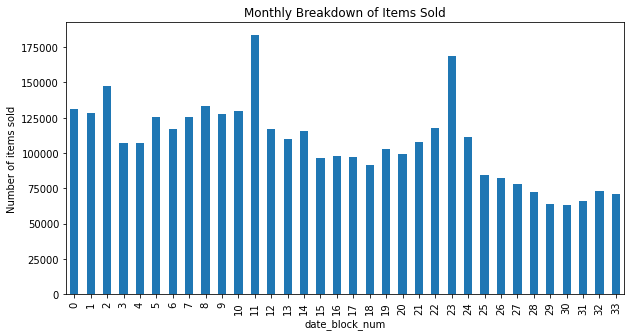

In [ ]:
sales.groupby('date_block_num')['item_cnt_day'].sum().plot.bar(figsize=(10, 5))
plt.title ("Monthly Breakdown of Items Sold")
plt.ylabel("Number of items sold")

In [ ]:
duplicate_rows_sales = sales[sales.duplicated()]
print("number of duplicate sales rows: ", duplicate_rows_sales.shape)

number of duplicate sales rows:  (6, 6)


In [ ]:
duplicate_rows_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-01-05,16,50,3423,999.0,1.0
1866340,2014-12-07,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


In [ ]:
print(sales.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [ ]:
sales["item_id"].value_counts()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
         ...  
593          1
13866        1
16574        1
20668        1
0            1
Name: item_id, Length: 21807, dtype: int64

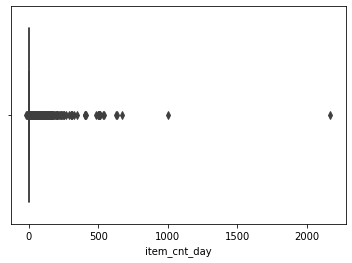

In [ ]:
sns.boxplot(x=sales ['item_cnt_day'])

In [ ]:
sales.loc[sales['item_cnt_day']>800]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [ ]:
items.loc[items['item_id']==20949]

,item_name,item_id,item_category_id
20949,Corporate package white shirt 1C Interest (34 ...,20949,71


In [ ]:
items.loc[items['item_id']==11373]

,item_name,item_id,item_category_id
11373,Delivery to the delivery point (Boxberry),11373,9


In [ ]:
shops.loc[shops['shop_id']==12]

,shop_name,shop_id
12,Shop Online Emergencies,12


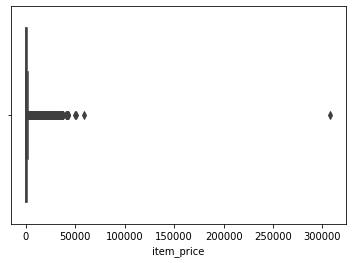

In [ ]:
sns.boxplot(x=sales ['item_price'])

In [ ]:
sales.loc[sales['item_price']>100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [ ]:
items.loc[items['item_id']==6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [ ]:
sales.loc[sales['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [ ]:
items.loc[items['item_id']==2973]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, Russian subtitles]",2973,19


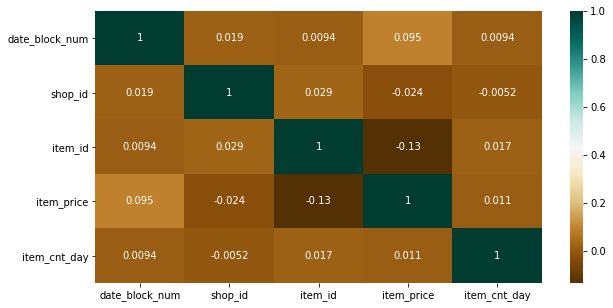

In [ ]:
plt.figure(figsize=(10,5))
c= sales.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

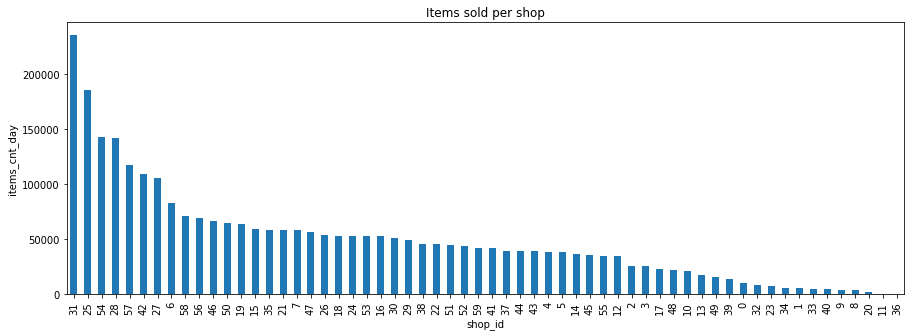

In [ ]:
sales.shop_id.value_counts().nlargest(60).plot(kind='bar', figsize=(15,5))
plt.title("Items sold per shop")
plt.ylabel('items_cnt_day')
plt.xlabel('shop_id');

Data Understanding Summary Findings
* There are no missing values in the data
* There are significant outliers in the data, two relate to item_price which appear to be an anomalies, 1 exceptionally high price and another item sold below 0. The others are count of items sold, one is delivery charges on a certain day and another is a tshirt sale both from shop 12 the online store

#DATA PREPARATION 
In this block we will:
* create new fields in categories file to group categories, and in shops to show the shop city 
* merge the sales, shops, item and category data
* split out Oct 2015 as our testing data, and rename Jan 13-Sep 15 as training
* perform a few extra steps of analysis on the combined data
* create new fields on the combined dataset for weekday, revenue
* decide what to do with our outliers
* ceate aggregated sales data for each shop 
* create lag features (did not use these)





In [ ]:
!pip install category_encoders

In [ ]:
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings

warnings.filterwarnings("ignore")

In [ ]:
categories['group']=categories['item_category_name'].str.extract(r'(^[\w\s]*)')
categories['group'] = categories['group'].str.strip()

categories['group_id'] = le.fit_transform(categories.group.values)
categories.sample(5)

,item_category_name,item_category_id,group,group_id
65,Gifts - Games (compact),65,Gifts,9
29,Games PC - Collector's Edition,29,Games PC,8
48,Books - Computer Books,48,Books,1
59,Music - Music video,59,Music,12
66,"Gifts - Cards, Stickers",66,Gifts,9


In [ ]:
shops['shop_name'] = shops['shop_name'].str.replace('!','').str.lstrip().str.rstrip()
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = le.fit_transform(shops['city'])
shops['shop_id'] = shops['shop_id']

In [ ]:
shops.head(15)

,shop_name,shop_id,city,city_code
0,"Yakutsk Ordzhonikidze, 56 Franc",0,Yakutsk,28
1,"Yakutsk TC ""Central"" Franc",1,Yakutsk,28
2,"Adygea TC ""Mega""",2,Adygea,0
3,"Balashikha TRC ""October-Kinomir""",3,Balashikha,1
4,"Volzhsky mall ""Volga Mall""",4,Volzhsky,26
5,"Vologda SEC ""Marmalade""",5,Vologda,25
6,"Voronezh (Plekhanovskaya, 13)",6,Voronezh,27
7,"Voronezh TRC ""Maksimir""",7,Voronezh,27
8,"Voronezh TRC City-Park ""City""",8,Voronezh,27
9,Itinerant trade,9,Itinerant,4


In [ ]:
itemCats = pd.merge(items,categories)
shopSales = pd.merge(sales,shops)
fullData = pd.merge(shopSales,itemCats)



In [ ]:
fullData.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,city_code,item_name,item_category_id,item_category_name,group,group_id
0,2013-02-01,0,59,22154,999.0,1.0,"Yaroslavl shopping center ""Altair""",Yaroslavl,29,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
1,2013-02-01,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
2,2013-03-01,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
3,2013-01-20,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
4,2013-01-23,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
5,2013-01-26,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
6,2015-08-27,31,25,22154,299.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
7,2015-02-09,32,25,22154,299.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
8,2013-01-23,0,24,22154,999.0,1.0,"Moscow TK ""Budenovsky"" (pav.K7)",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11
9,2015-10-10,33,24,22154,299.0,1.0,"Moscow TK ""Budenovsky"" (pav.K7)",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11


In [ ]:
trainData = fullData[(fullData.date_block_num >= 0) & (fullData.date_block_num < 33)]
testData = fullData[(fullData.date_block_num == 33)]
print(trainData.shape)
print(testData.shape)

(2882335, 14)
(53514, 14)


In [ ]:
trainData['day_of_week'] = trainData['date'].dt.dayofweek

In [ ]:
trainData['weekday_weekend'] = np.where((trainData['day_of_week'] >= 0) & 
                         (trainData['day_of_week'] <= 4) , 'weekday', 'weekend')

In [ ]:
trainData.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,city_code,item_name,item_category_id,item_category_name,group,group_id,day_of_week,weekday_weekend
0,2013-02-01,0,59,22154,999.0,1.0,"Yaroslavl shopping center ""Altair""",Yaroslavl,29,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,4,weekday
1,2013-02-01,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,4,weekday
2,2013-03-01,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,4,weekday
3,2013-01-20,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,6,weekend
4,2013-01-23,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,2,weekday
5,2013-01-26,0,25,22154,999.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,5,weekend
6,2015-08-27,31,25,22154,299.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,3,weekday
7,2015-02-09,32,25,22154,299.0,1.0,"Moscow TRC ""Atrium""",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,0,weekday
8,2013-01-23,0,24,22154,999.0,1.0,"Moscow TK ""Budenovsky"" (pav.K7)",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,2,weekday
10,2013-01-04,3,23,22154,999.0,1.0,"Moscow TK ""Budenovsky"" (pav.A2)",Moscow,11,Scene 2012 (BD),37,Movies - Blu-Ray,Movies,11,4,weekday


In [ ]:
trainData['revenue'] = trainData['item_cnt_day']*trainData['item_price']


Text(0, 0.5, 'Sales in Russian Rubles')

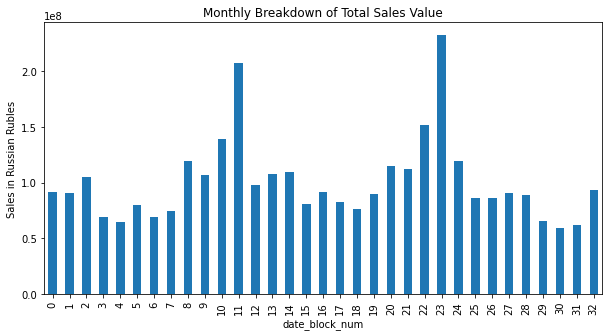

In [ ]:
trainData.groupby('date_block_num')['revenue'].sum().plot.bar(figsize=(10, 5))
plt.title ("Monthly Breakdown of Total Sales Value")
plt.ylabel("Sales in Russian Rubles")


Text(0, 0.5, 'Number of Items')

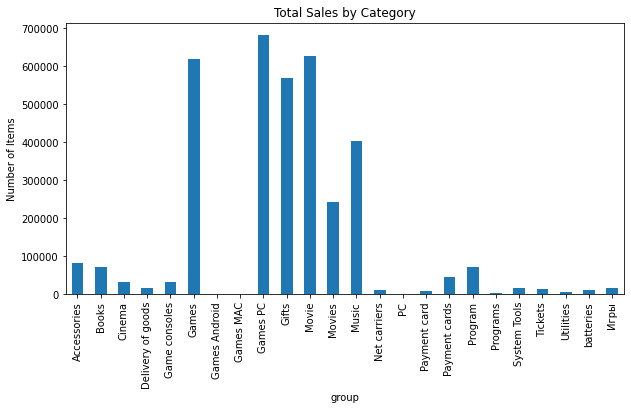

In [ ]:
trainData.groupby('group')['item_cnt_day'].sum().plot.bar(figsize=(10, 5))
plt.title ("Total Sales by Category")
plt.ylabel("Number of Items")


In [ ]:
salesGrid = []
cols = ['date_block_num','shop_id','item_id']
for i in range(33):
    sales = trainData[trainData['date_block_num'] == i]
    salesGrid.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))

salesGrid = pd.DataFrame(np.vstack(salesGrid), columns = cols,dtype=np.int32)

In [ ]:
aggregate = trainData.groupby(cols, as_index = False).agg({ 'item_cnt_day':'sum'})
aggregate.rename(columns = {'item_cnt_day':'item_cnt_month'},inplace = True)
salesDF = pd.merge(salesGrid,aggregate,how='left',on=cols).fillna(0)

In [ ]:
aggregate = trainData.groupby('item_id',as_index = False).agg({ 'item_price':'mean'})
aggregate.rename(columns ={'item_price':'avg_item_price'}, inplace = True)
salesDF = pd.merge(salesDF, aggregate,how='left', on='item_id').fillna(0)

In [ ]:
salesDF['item_cnt_month'] = np.clip(salesDF['item_cnt_month'], 0, 20)
salesDF.sort_values(cols, inplace=True)

In [ ]:
salesDF.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,avg_item_price
190029,0,0,19,0.0,28.000000
191223,0,0,27,0.0,1461.228571
189215,0,0,28,0.0,310.010465
194045,0,0,29,0.0,1759.285714
187702,0,0,32,6.0,250.818200
188933,0,0,33,3.0,253.939189
188167,0,0,34,0.0,144.213115
187701,0,0,35,1.0,375.828056
191224,0,0,40,0.0,245.096774
192005,0,0,41,0.0,237.790698


In [ ]:
testDF = pd.DataFrame(testData, columns = cols)

In [ ]:
salesDF = pd.concat([salesDF,testDF], ignore_index=True)

In [ ]:
salesDF.fillna(0, inplace = True)

In [ ]:
#salesDF = pd.merge(salesDF, shops, on=['shop_id'], how='left')
#salesDF = pd.merge(salesDF, items, on=['item_id'], how='left')
#salesDF = pd.merge(salesDF, categories, on=['item_category_id'], how='left')

In [ ]:
#def lag_feature(df, lags, col):
#    tmp = df[['date_block_num','shop_id','item_id',col]]
#   for i in lags:
#       shifted = tmp.copy()
#        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
#        shifted['date_block_num'] += i
#        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
#    return df

IndentationError: ignored

In [ ]:
# = lag_feature(salesDF, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
salesDF

,date_block_num,shop_id,item_id,item_cnt_month,avg_item_price
0,0,0,19,0.0,28.000000
1,0,0,27,0.0,1461.228571
2,0,0,28,0.0,310.010465
3,0,0,29,0.0,1759.285714
4,0,0,32,6.0,250.818200
...,...,...,...,...,...
10729187,33,20,21047,0.0,0.000000
10729188,33,20,21012,0.0,0.000000
10729189,33,20,20451,0.0,0.000000
10729190,33,20,20453,0.0,0.000000


#DATA MODELLING 
In this block we will:
* split our data into 3 groups - train on Jan '13 to Aug '15, validate against Sep '15, and then test on Oct '15
* use our XGBoost model to find the best iteration with lowest root mean squared error

In [ ]:
X_train = salesDF[salesDF['date_block_num'] < 32].drop('item_cnt_month',axis = 1)
y_train = salesDF[salesDF['date_block_num'] < 32].item_cnt_month

X_val = salesDF[salesDF['date_block_num'] == 32].drop('item_cnt_month',axis = 1)
y_val = salesDF[salesDF['date_block_num'] == 32].item_cnt_month


X_test  = salesDF[salesDF['date_block_num'] == 33].drop('item_cnt_month',axis = 1)

In [ ]:
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as skt
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet

In [ ]:
ts = time.time()

xgb = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    subsample=0.8,
    colsample_bytree=0.8,
    eta = 0.3,
    seed=42)
xgb.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[06:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:41:09] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.23266	validation_1-rmse:1.16776
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.22373	validation_1-rmse:1.15854
[2]	validation_0-rmse:1.21684	validation_1-rmse:1.15066
[3]	validation_0-rmse:1.21175	validation_1-rmse:1.14578
[4]	validation_0-rmse:1.20755	validation_1-rmse:1.14198
[5]	validation_0-rmse:1.20243	validation_1-rmse:1.13655
[6]	validation_0-rmse:1.19813	validation_1-rmse:1.13201
[7]	validation_0-rmse:1.19556	validation_1-rmse:1.12967
[8]	validation_0-rmse:1.19348	validation_1-rmse:1.12

1752.5112719535828

#DATA EVALUATION 
In this block we will:
* review the features in the data which have the most importance
* show the training and testing scores for the model
* plot the results 


In [ ]:
print(xgb.feature_importances_)

[0.14923215 0.21859834 0.35228813 0.2798814 ]


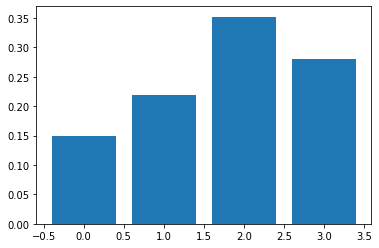

In [ ]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [ ]:
features_importance = xgb.get_booster().get_fscore()
f_results = pd.DataFrame(features_importance.items(), columns=['feature_name', 'fscore'])
f_results.sort_values(by='fscore',ascending=False,inplace=True)
f_results.reset_index(inplace=True)
top_features = f_results['feature_name']
top_features

0           shop_id
1    avg_item_price
2           item_id
3    date_block_num
Name: feature_name, dtype: object

In [ ]:
testingData=salesDF[salesDF['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_pred = xgb.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, y_pred)))
y_pred = xgb.predict(testingData)

1.0860568809613769


In [ ]:
print('Train Score:', xgb.score(X_train, y_train))
print('Test Score :', xgb.score(X_val, y_val))

Train Score: 0.1481679838714023
Test Score : 0.1146027673962432


In [ ]:
results = xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

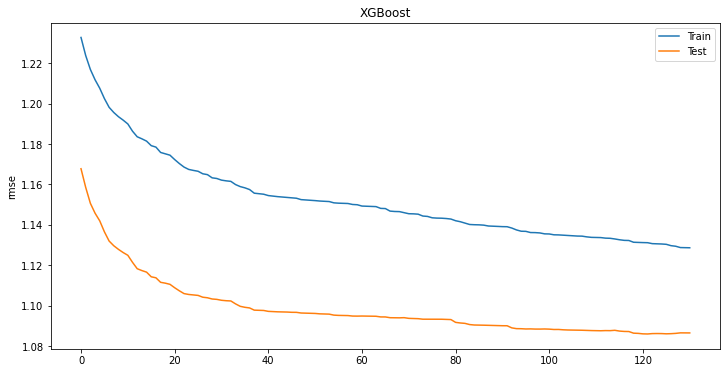

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost')
plt.show()